### Imports

In [71]:
import numpy as np
from numba import cuda
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from SEACells.core import SEACells, summarize_by_SEACell
from SEACells.plot import plot_initialization
import seaborn as sns
import anndata
import scanpy as sc
import pandas as pd
import sklearn
from scipy.sparse import csr_matrix
import copy

### Into to SEACells

In [2]:
# Load data
ad = sc.read("/home/aparna/DATA/aparnakumar/cd34_multiome_rna_no_bcells.h5ad")

View the anndata object. 

/home/aparna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


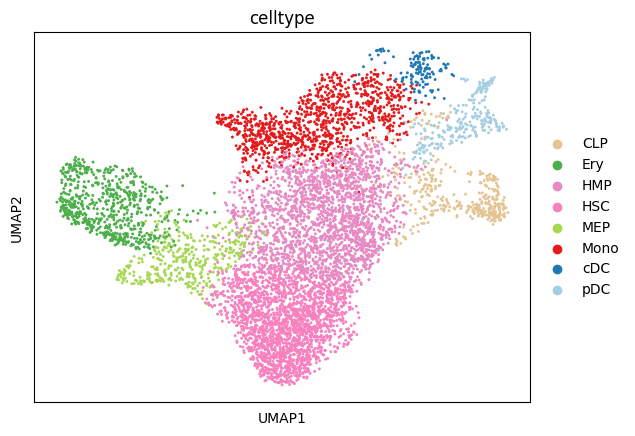

In [3]:
# Plot cell-types for reference
%matplotlib inline
sc.pl.umap(ad, color = 'celltype')
plt.show()

### Pre-processing

In [4]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [5]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1500)

In [6]:
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

In [7]:
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'ct_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap', 'log1p'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [8]:
ad.shape[0]

6881

In [9]:
# Going to be dealing with two different versions, so create the versioning split here 
length = 1000
ad_1 = ad[:length].copy()
ad_2 = ad[:length].copy()

In [10]:
ad_1.obs.shape

(1000, 13)

In [11]:
ad_2

AnnData object with n_obs × n_vars = 1000 × 12464
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'ct_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap', 'log1p'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

For refresher on what obsm is: https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html# 

"Key-indexed multi-dimensional observations annotation of length #observations. If passing a ndarray, it needs to have a structured datatype."

In [12]:
ad_1.obsm

AxisArrays with keys: DM_EigenVectors, X_FDL, X_pca, X_umap

### Model

* We are choosing the build with PCA (Principal component analysis)
* 90 metacells 

In [13]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

We create two versions of the model for comparison purposes. 

In [20]:
model_1 = SEACells(ad_1, 
    use_gpu=False, 
    use_sparse=False, 
    build_kernel_on=build_kernel_on, 
    n_SEACells=n_SEACells, 
    n_waypoint_eigs=n_waypoint_eigs,
    convergence_epsilon = 1e-5)

NOT SPARSE AND NOT GPUT
TRYING SEACellsCPUDense
Welcome to SEACells!


In [21]:
model_2 = SEACells(ad_2, 
    use_gpu=False, 
    use_sparse=False, 
    build_kernel_on=build_kernel_on, 
    n_SEACells=n_SEACells, 
    n_waypoint_eigs=n_waypoint_eigs,
    convergence_epsilon = 1e-5)

NOT SPARSE AND NOT GPUT
TRYING SEACellsCPUDense
Welcome to SEACells!


In [22]:
model_1.construct_kernel_matrix()
M_1 = model_1.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...


In [23]:
model_2.construct_kernel_matrix()
M_2 = model_2.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...


In [24]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

/home/aparna/.local/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


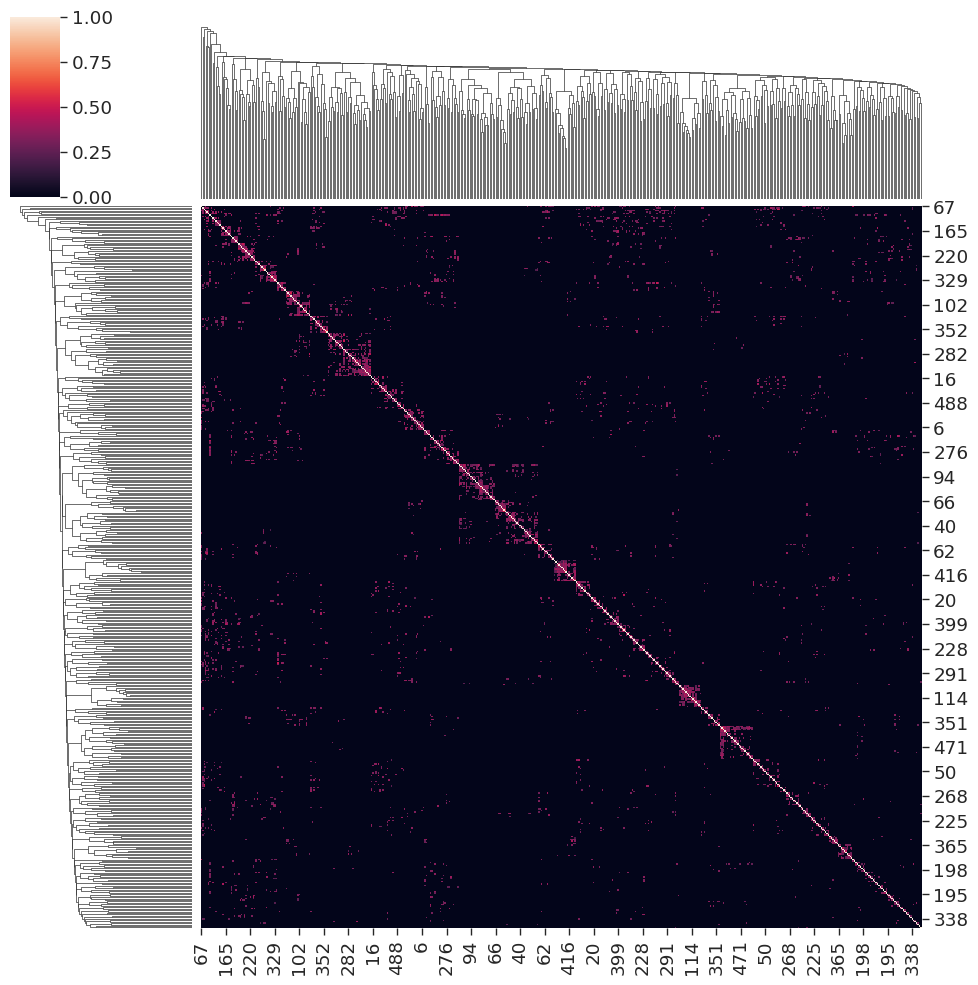

In [25]:
sns.clustermap(M_1.toarray()[:500,:500])
plt.show()

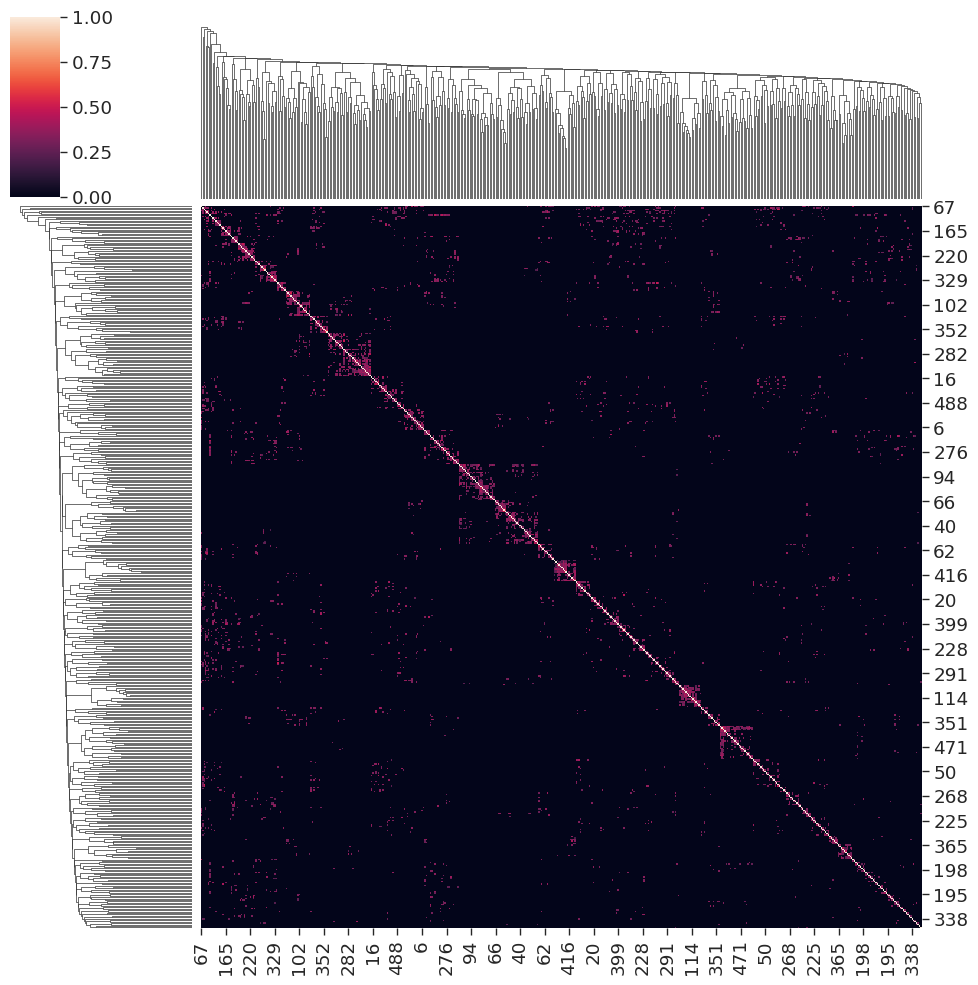

In [26]:
sns.clustermap(M_2.toarray()[:500,:500])

### Implement truncated SVD for our second version

In [27]:
num_components = list(range(100, 1001, 100))
num_components

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [84]:
from sklearn.decomposition import TruncatedSVD
truncated_svd = TruncatedSVD(n_components=1000)

In [85]:
M_transform = truncated_svd.fit_transform(M_2)

In [86]:
M_transform.shape

(1000, 1000)

#### Here is where we want to change the number

In [87]:
y = np.cumsum(truncated_svd.explained_variance_ratio_)

In [88]:
num_components = np.where(y>0.60)[0][0]
num_components

97

In [89]:
new_kernel_matrix = M_transform[:, :num_components]

In [90]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

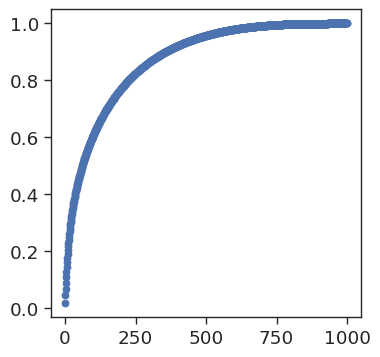

In [91]:
plt.scatter(x= np.arange(len(truncated_svd.explained_variance_ratio_)), y = y)
plt.show()

### Applying new kernel matrix

In [92]:
# Time consuming cell 
model_2.kernel_matrix = csr_matrix(new_kernel_matrix.T)

model_2.K = model_2.kernel_matrix.T @ model_2.kernel_matrix

In [93]:
model_2.kernel_matrix.shape

(97, 1000)

In [94]:
model_2.K.shape

(1000, 1000)

In [95]:
# Count number of 0s in model_2.K 
np.count_nonzero(model_2.K.toarray() == 0)

0

### Proceed with model

In [96]:
model_1.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...


100%|██████████| 20/20 [00:00<00:00, 382.34it/s]

Done.
Sampling waypoints ...
Done.
Selecting 80 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...
Selecting 10 cells from greedy initialization.


In [97]:
# Initialize archetypes
# Write as convex combinations
model_2.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...


100%|██████████| 18/18 [00:00<00:00, 282.75it/s]

Done.
Sampling waypoints ...
Done.
Selecting 82 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...
Selecting 8 cells from greedy initialization.


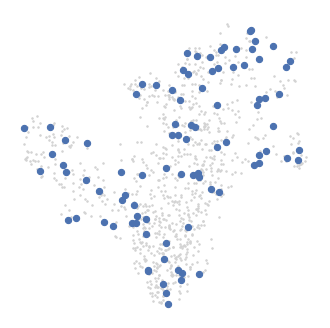

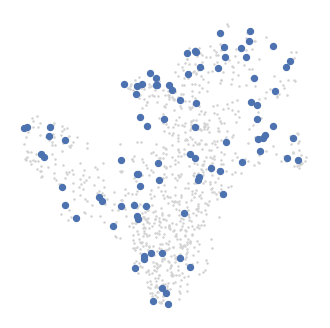

In [98]:
# Plot the initilization to ensure they are spread across phenotypic space

plot_initialization(ad_1, model_1)

# Plot the initilization to ensure they are spread across phenotypic space
plot_initialization(ad_2, model_2)

In [99]:
# Time consuming cell
model_1.fit(min_iter=10, max_iter=150)

Randomly initialized A matrix.
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.


In [ ]:
# Time consuming cell
model_2.fit(min_iter=10, max_iter=150)

Randomly initialized A matrix.
Setting convergence threshold at 0.00029
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Starting iteration 50.
Completed iteration 50.
Starting iteration 60.
Completed iteration 60.
Starting iteration 70.
Completed iteration 70.
Converged after 77 iterations.


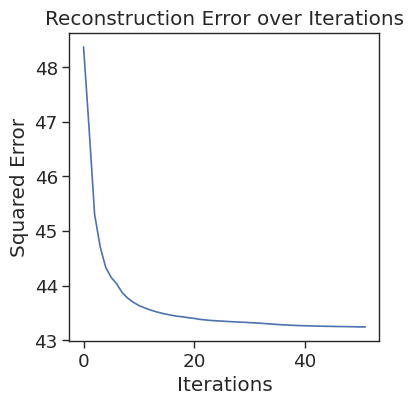

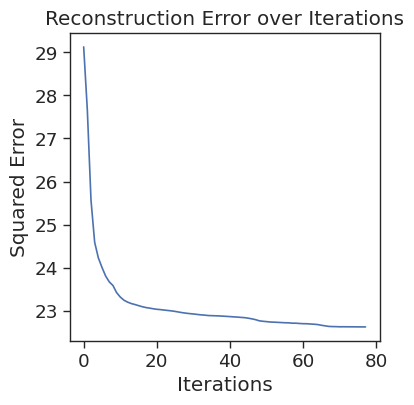

In [ ]:
# Check for convergence 
model_1.plot_convergence()

# Check for convergence 
model_2.plot_convergence()

In [ ]:
ad_1.obs.head()

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,DoubletScores,n_counts,leiden,phenograph,log_n_counts,celltype,Metacell,SEACell
index,,,,,,,,,,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,rep1,4746,16056.0,1707.0,10.631539,0,0.063387,12808.090820,3,2,4.205637,HMP,cd34_multiome_rep1#AAACAGCCACTCGCTC-1,SEACell-84
cd34_multiome_rep1#AAACAGCCACTGACCG-1,rep1,2804,6776.0,1357.0,20.026566,0,0.074074,9910.753906,6,4,3.830973,Mono,cd34_multiome_rep2#ATTACCGCAAACTAAG-1,SEACell-15
cd34_multiome_rep1#AAACAGCCATAATCAC-1,rep1,2292,5181.0,645.0,12.449334,0,0.086809,8628.223633,0,1,3.714414,HSC,cd34_multiome_rep1#TCCTTCAAGTCATGCG-1,SEACell-61
cd34_multiome_rep1#AAACATGCAAATTCGT-1,rep1,2085,4241.0,475.0,11.200189,0,0.092614,8393.524414,0,1,3.627468,HSC,cd34_multiome_rep1#TCCTTCAAGTCATGCG-1,SEACell-61
cd34_multiome_rep1#AAACATGCAGCATGTC-1,rep1,4617,16824.0,2526.0,15.014265,0,0.063387,12339.052734,2,5,4.225929,Ery,cd34_multiome_rep1#TCACCTCAGCTGTAAC-1,SEACell-13


In [ ]:
ad_2.obs.head()

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,DoubletScores,n_counts,leiden,phenograph,log_n_counts,celltype,Metacell,SEACell
index,,,,,,,,,,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,rep1,4746,16056.0,1707.0,10.631539,0,0.063387,12808.090820,3,2,4.205637,HMP,cd34_multiome_rep1#AAACAGCCACTCGCTC-1,SEACell-89
cd34_multiome_rep1#AAACAGCCACTGACCG-1,rep1,2804,6776.0,1357.0,20.026566,0,0.074074,9910.753906,6,4,3.830973,Mono,cd34_multiome_rep2#ATTACCGCAAACTAAG-1,SEACell-64
cd34_multiome_rep1#AAACAGCCATAATCAC-1,rep1,2292,5181.0,645.0,12.449334,0,0.086809,8628.223633,0,1,3.714414,HSC,cd34_multiome_rep1#TCCTTCAAGTCATGCG-1,SEACell-15
cd34_multiome_rep1#AAACATGCAAATTCGT-1,rep1,2085,4241.0,475.0,11.200189,0,0.092614,8393.524414,0,1,3.627468,HSC,cd34_multiome_rep1#TCCTTCAAGTCATGCG-1,SEACell-15
cd34_multiome_rep1#AAACATGCAGCATGTC-1,rep1,4617,16824.0,2526.0,15.014265,0,0.063387,12339.052734,2,5,4.225929,Ery,cd34_multiome_rep1#TCACCTCAGCTGTAAC-1,SEACell-25


Datasets can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. The output of this function is an anndata object of shape n_metacells x original_data_dimension. Data is unnormalized and raw aggregated counts are stored in X. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

By default, ad.raw is used for summarization. Other layers present in the anndata can be specified using the parameter summarize_layer parameter.

In [ ]:
SEACell_ad_1 = summarize_by_SEACell(ad_1, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad_1

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:00<00:00, 324.65it/s]


AnnData object with n_obs × n_vars = 90 × 12464
    layers: 'raw'

In [ ]:
SEACell_ad_2 = summarize_by_SEACell(ad_2, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad_2

100%|██████████| 90/90 [00:00<00:00, 311.94it/s]


AnnData object with n_obs × n_vars = 90 × 12464
    layers: 'raw'

### Normalization

In [ ]:
sc.pp.normalize_per_cell(SEACell_ad_1)
sc.pp.log1p(SEACell_ad_1)
sc.pp.highly_variable_genes(SEACell_ad_1, n_top_genes=1500)

In [ ]:
sc.pp.normalize_per_cell(SEACell_ad_2)
sc.pp.log1p(SEACell_ad_2)
sc.pp.highly_variable_genes(SEACell_ad_2, n_top_genes=1500)

In [ ]:
sc.tl.pca(SEACell_ad_1, n_comps=50, use_highly_variable=True)

sc.tl.pca(SEACell_ad_2, n_comps=50, use_highly_variable=True)

In [ ]:
SEACell_ad_1

AnnData object with n_obs × n_vars = 90 × 12464
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [ ]:
SEACell_ad_2

AnnData object with n_obs × n_vars = 90 × 12464
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [ ]:
sc.pp.neighbors(SEACell_ad_1, use_rep='X_pca')
sc.pp.neighbors(SEACell_ad_2, use_rep='X_pca')

In [ ]:
sc.tl.umap(SEACell_ad_1)
sc.tl.umap(SEACell_ad_2)

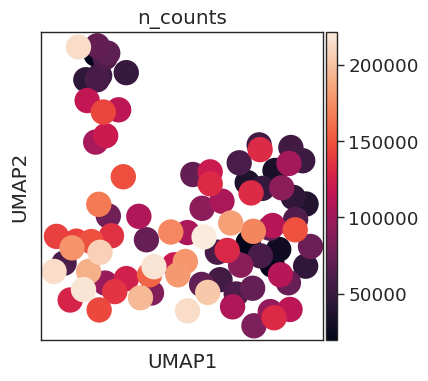

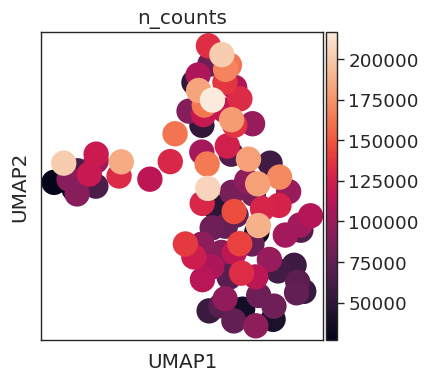

In [ ]:
sc.pl.umap(SEACell_ad_1, color = 'n_counts')

sc.pl.umap(SEACell_ad_2, color = 'n_counts')

## Annotate SEACell_ad with ‘average’ cell type - treat ad.obs as a DataFrame and then use a groupby on ‘SEACell’ to figure out the modal cell type

In [ ]:
# Get the average cell-types
avg_cell_1 = ad_1.obs.groupby("SEACell")["celltype"].agg(pd.Series.mode)
avg_cell_2 = ad_2.obs.groupby("SEACell")["celltype"].agg(pd.Series.mode)

In [ ]:
celltype_purity_1 = ad_1.obs.groupby("SEACell")["celltype"].apply(lambda x : x.value_counts()[0]/sum(x.value_counts()))
celltype_purity_2 = ad_2.obs.groupby("SEACell")["celltype"].apply(lambda x : x.value_counts()[0]/sum(x.value_counts()))


In [ ]:
SEACell_ad_1.obs.index.name = 'SEACell'
SEACell_ad_2.obs.index.name = 'SEACell'

In [ ]:
# Complete the join
SEACell_ad_1.obs = SEACell_ad_1.obs.merge(avg_cell_1, how='inner', on='SEACell')
SEACell_ad_2.obs = SEACell_ad_2.obs.merge(avg_cell_2, how='inner', on='SEACell')

In [ ]:
SEACell_ad_1.obs.head()

,n_counts,celltype
SEACell,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,120980.939434,HMP
cd34_multiome_rep1#ATTTGCAAGGTGTTAC-1,97910.591860,HMP
cd34_multiome_rep1#ACTTGTAAGGCGCTAC-1,139773.703258,HSC
cd34_multiome_rep1#ACTAATCCATCGCTTT-1,90908.401302,HSC
cd34_multiome_rep1#AGCGCTCAGCTATGAC-1,312157.212926,Ery


In [ ]:
SEACell_ad_2.obs.head()

,n_counts,celltype
SEACell,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,108651.767506,HMP
cd34_multiome_rep1#ACCTGTTGTTACGCAA-1,80155.503244,Mono
cd34_multiome_rep1#ACTTGTAAGGCGCTAC-1,139522.457952,HSC
cd34_multiome_rep1#CATCATGCATAGGCGA-1,218803.119406,HSC
cd34_multiome_rep1#CAACCCTTCATTACTC-1,265675.898798,Ery


## Comparisons

#### Initial Graphs

/home/aparna/.local/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/aparna/.local/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


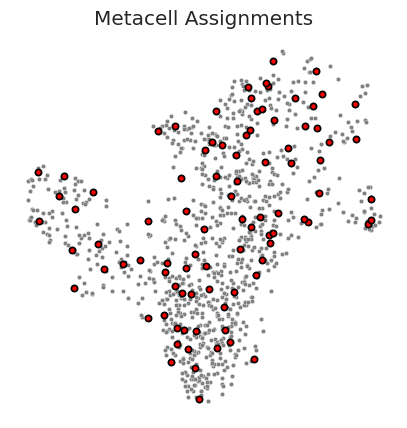

/home/aparna/.local/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/aparna/.local/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


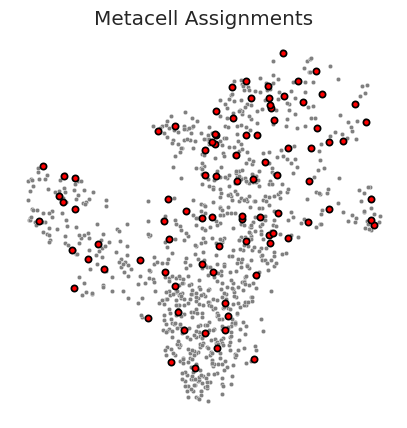

In [ ]:
SEACells.plot.plot_2D(ad_1, key='X_umap', colour_metacells=False)
SEACells.plot.plot_2D(ad_2, key='X_umap', colour_metacells=False)

/home/aparna/.local/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/aparna/.local/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


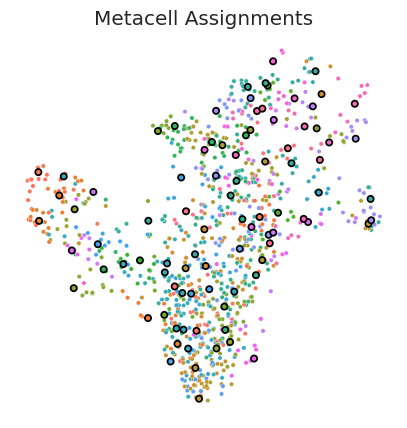

/home/aparna/.local/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/aparna/.local/lib/python3.8/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


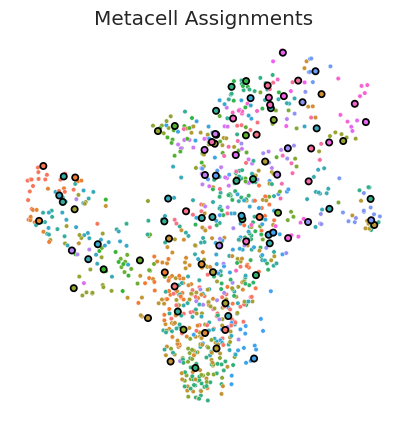

In [ ]:
SEACells.plot.plot_2D(ad_1, key='X_umap', colour_metacells=True)
SEACells.plot.plot_2D(ad_2, key='X_umap', colour_metacells=True)

/home/aparna/.local/lib/python3.8/site-packages/SEACells/plot.py:120: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


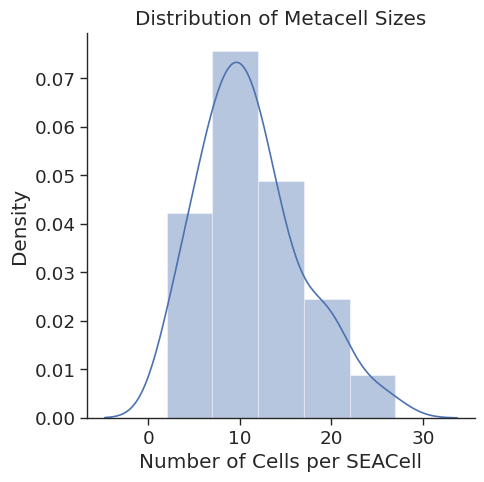

/home/aparna/.local/lib/python3.8/site-packages/SEACells/plot.py:120: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


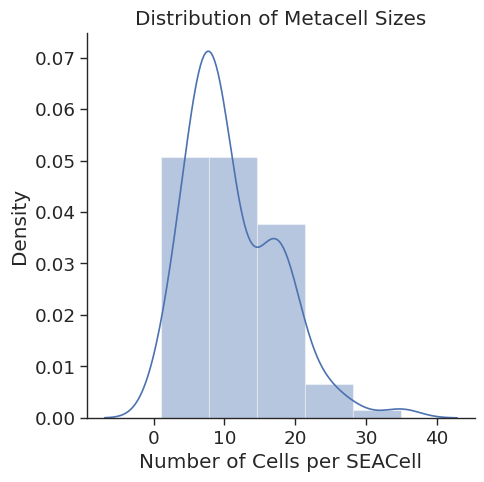

,size
SEACell,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,10
cd34_multiome_rep1#AACAAGCCAATAAGCA-1,17
cd34_multiome_rep1#AACAGGATCAATGACC-1,19
cd34_multiome_rep1#AACCTTAAGCCTGACA-1,10
cd34_multiome_rep1#AACGCCCAGTCACTCC-1,24
...,...
cd34_multiome_rep1#CAGGTCCAGTGATTCA-1,3
cd34_multiome_rep1#CATCATGCATAGGCGA-1,25
cd34_multiome_rep1#CATCGCTTCCGCACAA-1,17


In [ ]:
SEACells.plot.plot_SEACell_sizes(ad_1, bins=5)

SEACells.plot.plot_SEACell_sizes(ad_2, bins=5)

In [ ]:
ad_1.obs.head()

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,DoubletScores,n_counts,leiden,phenograph,log_n_counts,celltype,Metacell,SEACell
index,,,,,,,,,,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,rep1,4746,16056.0,1707.0,10.631539,0,0.063387,12808.090820,3,2,4.205637,HMP,cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#AAACAGCCACTCGCTC-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,rep1,2804,6776.0,1357.0,20.026566,0,0.074074,9910.753906,6,4,3.830973,Mono,cd34_multiome_rep2#ATTACCGCAAACTAAG-1,cd34_multiome_rep1#ATTTGCAAGGTGTTAC-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,rep1,2292,5181.0,645.0,12.449334,0,0.086809,8628.223633,0,1,3.714414,HSC,cd34_multiome_rep1#TCCTTCAAGTCATGCG-1,cd34_multiome_rep1#ACTTGTAAGGCGCTAC-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,rep1,2085,4241.0,475.0,11.200189,0,0.092614,8393.524414,0,1,3.627468,HSC,cd34_multiome_rep1#TCCTTCAAGTCATGCG-1,cd34_multiome_rep1#ACTAATCCATCGCTTT-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,rep1,4617,16824.0,2526.0,15.014265,0,0.063387,12339.052734,2,5,4.225929,Ery,cd34_multiome_rep1#TCACCTCAGCTGTAAC-1,cd34_multiome_rep1#AGCGCTCAGCTATGAC-1


#### Adjusted Rand Score 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

In [ ]:
sklearn.metrics.adjusted_rand_score(ad_1.obs["SEACell"], ad_2.obs["SEACell"])

0.5469843620831494

#### Normalized Mutual Info Score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html

In [ ]:
sklearn.metrics.normalized_mutual_info_score(ad_1.obs["SEACell"], ad_2.obs["SEACell"])

0.8211862525021199

#### Purity

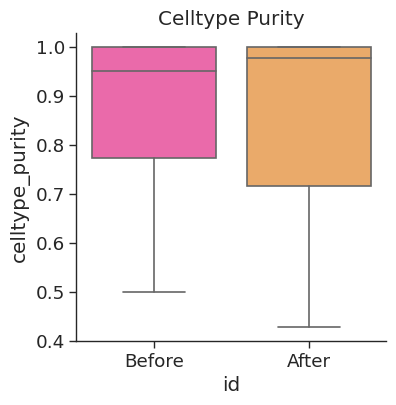

                                      celltype  celltype_purity      id
SEACell                                                                
cd34_multiome_rep1#AAACAGCCACTCGCTC-1      HMP         1.000000  Before
cd34_multiome_rep1#AACAAGCCAATAAGCA-1     Mono         1.000000  Before
cd34_multiome_rep1#AACCGCTCACCTACGG-1      HMP         0.600000  Before
cd34_multiome_rep1#AACCTTAAGCCTGACA-1     Mono         0.909091  Before
cd34_multiome_rep1#AACGCCCAGTCACTCC-1      MEP         0.666667  Before
                                      celltype  celltype_purity     id
SEACell                                                               
cd34_multiome_rep1#AAACAGCCACTCGCTC-1      HMP         1.000000  After
cd34_multiome_rep1#AACAAGCCAATAAGCA-1     Mono         1.000000  After
cd34_multiome_rep1#AACAGGATCAATGACC-1      HSC         0.842105  After
cd34_multiome_rep1#AACCTTAAGCCTGACA-1     Mono         0.800000  After
cd34_multiome_rep1#AACGCCCAGTCACTCC-1      HSC         0.708333  After

In [ ]:
SEACell_purity_1 = SEACells.evaluate.compute_celltype_purity(ad_1, 'celltype')
SEACell_purity_1['id'] = "Before"
SEACell_purity_2 = SEACells.evaluate.compute_celltype_purity(ad_2, 'celltype')
SEACell_purity_2['id'] = "After"

plt.figure(figsize=(4,4))
sns.boxplot(data=pd.concat([SEACell_purity_1, SEACell_purity_2]), x='id', y='celltype_purity', palette='spring')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

print(SEACell_purity_1.head())
print(SEACell_purity_2.head())

#### Compactness

Determing nearest neighbor graph...
Determing nearest neighbor graph...


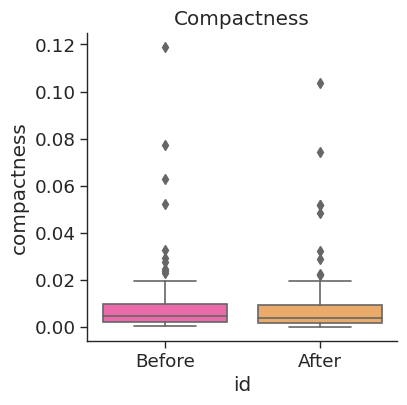

                                       compactness      id
SEACell                                                   
cd34_multiome_rep1#AAACAGCCACTCGCTC-1     0.004752  Before
cd34_multiome_rep1#AACAAGCCAATAAGCA-1     0.000760  Before
cd34_multiome_rep1#AACCGCTCACCTACGG-1     0.118947  Before
cd34_multiome_rep1#AACCTTAAGCCTGACA-1     0.006084  Before
cd34_multiome_rep1#AACGCCCAGTCACTCC-1     0.011004  Before
                                       compactness     id
SEACell                                                  
cd34_multiome_rep1#AAACAGCCACTCGCTC-1     0.007095  After
cd34_multiome_rep1#AACAAGCCAATAAGCA-1     0.000721  After
cd34_multiome_rep1#AACAGGATCAATGACC-1     0.001398  After
cd34_multiome_rep1#AACCTTAAGCCTGACA-1     0.007122  After
cd34_multiome_rep1#AACGCCCAGTCACTCC-1     0.007701  After


In [ ]:
compactness1 = SEACells.evaluate.compactness(ad_1, 'X_pca')
compactness1['id'] = "Before"
compactness2 = SEACells.evaluate.compactness(ad_2, 'X_pca')
compactness2['id'] = "After"

plt.figure(figsize=(4,4))
# sns.boxplot(data=compactness, y='compactness')
sns.boxplot(data=pd.concat([compactness1, compactness2]), x='id', y='compactness', palette='spring')

plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

print(compactness1.head())
print(compactness2.head())

#### Separation

Determing nearest neighbor graph...
Determing nearest neighbor graph...


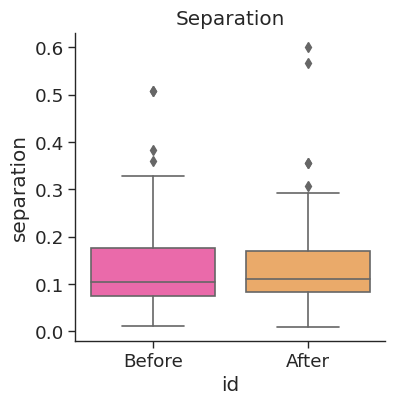

                                       separation      id
SEACell                                                  
cd34_multiome_rep1#AAACAGCCACTCGCTC-1    0.141103  Before
cd34_multiome_rep1#AACAAGCCAATAAGCA-1    0.095987  Before
cd34_multiome_rep1#AACCGCTCACCTACGG-1    0.360642  Before
cd34_multiome_rep1#AACCTTAAGCCTGACA-1    0.090579  Before
cd34_multiome_rep1#AACGCCCAGTCACTCC-1    0.183674  Before
                                       separation     id
SEACell                                                 
cd34_multiome_rep1#AAACAGCCACTCGCTC-1    0.217563  After
cd34_multiome_rep1#AACAAGCCAATAAGCA-1    0.107030  After
cd34_multiome_rep1#AACAGGATCAATGACC-1    0.086522  After
cd34_multiome_rep1#AACCTTAAGCCTGACA-1    0.143075  After
cd34_multiome_rep1#AACGCCCAGTCACTCC-1    0.223860  After


In [ ]:
separation1 = SEACells.evaluate.separation(ad_1, 'X_pca',nth_nbr=1)
separation1['id'] = "Before"

separation2 = SEACells.evaluate.separation(ad_2, 'X_pca',nth_nbr=1)
separation2['id'] = "After"


plt.figure(figsize=(4,4))
# sns.boxplot(data=separation, y='separation')
sns.boxplot(data=pd.concat([separation1, separation2]), x='id', y='separation', palette='spring')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

print(separation1.head())
print(separation2.head())


#### Heatmap

In [ ]:
pairs = pd.DataFrame({"Before": ad_1.obs["SEACell"], "After": ad_2.obs["SEACell"]})
pairs = pairs.reset_index(drop=True)

SEACell_pairings = pairs.groupby(["Before", "After"], as_index=False).size()
SEACell_pairings


,Before,After,size
0,cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#AAACAGCCACTCGCTC-1,9
1,cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#CATCGCTTCCGCACAA-1,2
2,cd34_multiome_rep1#AACAAGCCAATAAGCA-1,cd34_multiome_rep1#AACAAGCCAATAAGCA-1,15
3,cd34_multiome_rep1#AACAAGCCAATAAGCA-1,cd34_multiome_rep1#ACCTAAATCAAGGACA-1,3
4,cd34_multiome_rep1#AACAAGCCAATAAGCA-1,cd34_multiome_rep1#ACCTGGATCCTCATGC-1,2
...,...,...,...
279,cd34_multiome_rep1#CATGCGGGTTTGCGAA-1,cd34_multiome_rep1#AACAAGCCAATAAGCA-1,1
280,cd34_multiome_rep1#CATGCGGGTTTGCGAA-1,cd34_multiome_rep1#AATTACCCATTGCGAC-1,12
281,cd34_multiome_rep1#CATGCGGGTTTGCGAA-1,cd34_multiome_rep1#ACCTAAATCAAGGACA-1,3
282,cd34_multiome_rep1#CATGCGGGTTTGCGAA-1,cd34_multiome_rep1#ACCTGGATCCTCATGC-1,5


In [ ]:
SEACell_pairings.shape

(284, 3)

In [ ]:
heatmap_data = pd.pivot_table(SEACell_pairings, values='size', index=['Before'], columns='After')
heatmap_data = heatmap_data.fillna(0)

heatmap_data

After,cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#AACAAGCCAATAAGCA-1,cd34_multiome_rep1#AACAGGATCAATGACC-1,cd34_multiome_rep1#AACCTTAAGCCTGACA-1,cd34_multiome_rep1#AACGCCCAGTCACTCC-1,cd34_multiome_rep1#AACTTAGTCACATTGA-1,cd34_multiome_rep1#AAGCGTTTCGTTAGTA-1,cd34_multiome_rep1#AAGCTATGTCAATACG-1,cd34_multiome_rep1#AAGCTCCCAGGCGATA-1,cd34_multiome_rep1#AAGGATTAGGAGTAAT-1,...,cd34_multiome_rep1#CACATTAAGCTCCTTA-1,cd34_multiome_rep1#CACCGGTAGAGGATAT-1,cd34_multiome_rep1#CACGCTAAGATACTTG-1,cd34_multiome_rep1#CACTAGCCAACTGGCT-1,cd34_multiome_rep1#CAGCATTAGCGCCTTT-1,cd34_multiome_rep1#CAGGTCCAGTGATTCA-1,cd34_multiome_rep1#CATCATGCATAGGCGA-1,cd34_multiome_rep1#CATCGCTTCCGCACAA-1,cd34_multiome_rep1#CATGAGGCACAAAGGT-1,cd34_multiome_rep1#CATTGTGCAAAGCTAA-1
Before,,,,,,,,,,,,,,,,,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
cd34_multiome_rep1#AACAAGCCAATAAGCA-1,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cd34_multiome_rep1#AACCGCTCACCTACGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cd34_multiome_rep1#AACCTTAAGCCTGACA-1,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cd34_multiome_rep1#AACGCCCAGTCACTCC-1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cd34_multiome_rep1#CAGGTCCAGTGATTCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
cd34_multiome_rep1#CATAACGGTCTAACAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cd34_multiome_rep1#CATCATGCATAGGCGA-1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0


In [ ]:
# SEACell_dict = {}

# for SEACell_1 in ad_1.obs["SEACell"]:
#     for SEACell_2 in ad_2.obs["SEACell"]: 
#         combo = (SEACell_1, SEACell_2)
#         reverse_combo = (SEACell_2, SEACell_1)
#         if combo in SEACell_dict: 
#             SEACell_dict[combo] = SEACell_dict[combo] +  1 
#         elif reverse_combo in SEACell_dict: 
#             SEACell_dict[reverse_combo] = SEACell_dict[reverse_combo] +  1 
#         else: 
#             SEACell_dict[combo] = 1   

# temp = pd.DataFrame.from_dict(SEACell_dict, orient='index', columns = ["Count"])
# SEACell_before, SEACell_after = zip(*temp.index)


# SEACell_pairings = pd.DataFrame({"Before": SEACell_before, "After": SEACell_after, "Count": list(temp["Count"])})

# print((len(SEACell_before), len(SEACell_after), len(list(temp["Count"]))))

# SEACell_pairings.head()

In [ ]:
# SEACell_pairings = SEACell_pairings.pivot("Before", "After")
# SEACell_pairings.shape

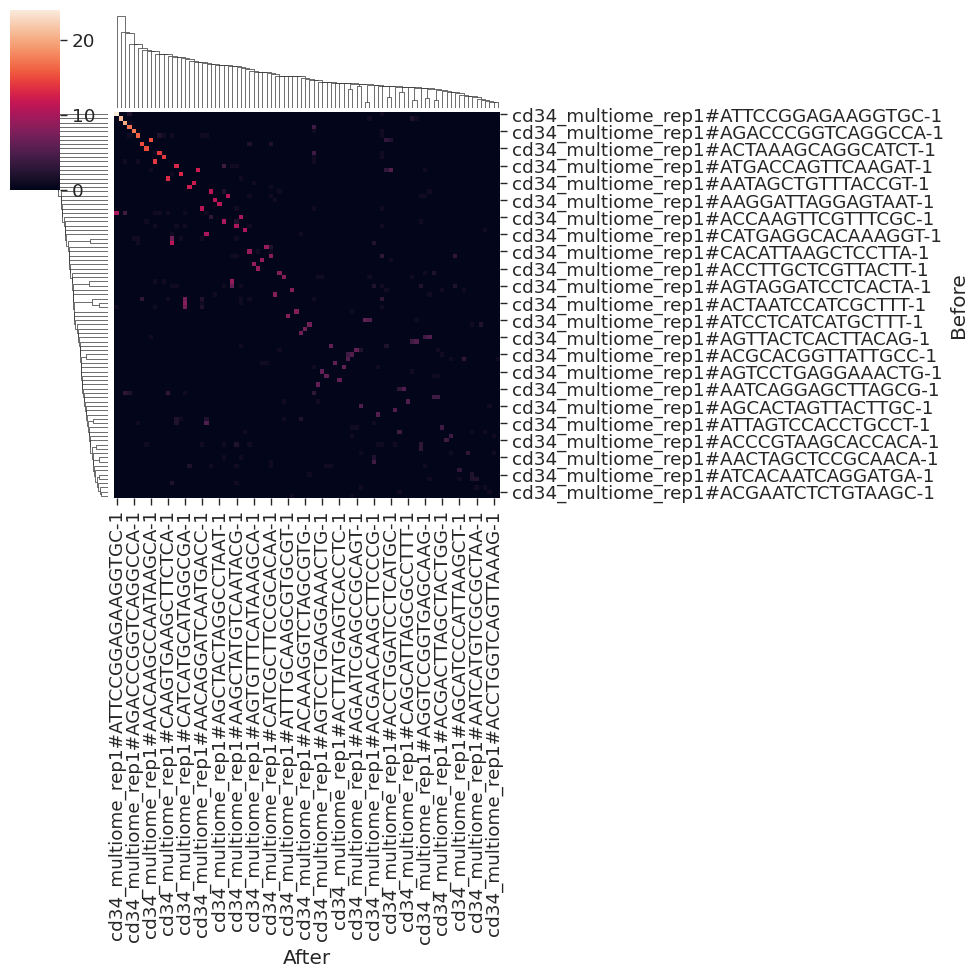

In [ ]:
sns.clustermap(heatmap_data)

<AxesSubplot: xlabel='After', ylabel='Before'>

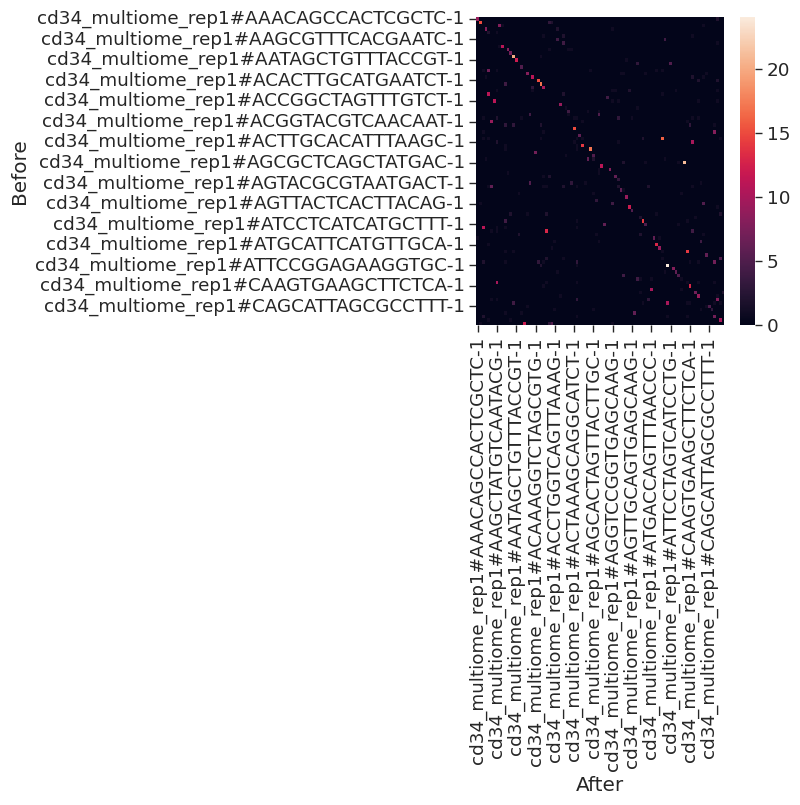

In [ ]:
sns.heatmap(data= heatmap_data)